c:\Users\furaf\anaconda3\envs\spade_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\furaf\anaconda3\envs\spade_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


load train set feature from: ./result\temp\train_bottle.pkl


| feature extraction | test | bottle |:   0%|          | 0/3 [00:00<?, ?it/s]

--- Final Mask Check for item 0 ---
Image path: ../data\mvtec_anomaly_detection\bottle\test\broken_large\000.png
Mask tensor unique values: tensor([0., 1.])
------------------------------------
--- Final Mask Check for item 1 ---
Image path: ../data\mvtec_anomaly_detection\bottle\test\broken_large\001.png
Mask tensor unique values: tensor([0., 1.])
------------------------------------
--- Final Mask Check for item 2 ---
Image path: ../data\mvtec_anomaly_detection\bottle\test\broken_large\002.png
Mask tensor unique values: tensor([0., 1.])
------------------------------------
--- Final Mask Check for item 3 ---
Image path: ../data\mvtec_anomaly_detection\bottle\test\broken_large\003.png
Mask tensor unique values: tensor([0., 1.])
------------------------------------
--- Final Mask Check for item 4 ---
Image path: ../data\mvtec_anomaly_detection\bottle\test\broken_large\004.png
Mask tensor unique values: tensor([0., 1.])
------------------------------------
--- Final Mask Check for item 

| feature extraction | test | bottle |:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

--- Final Mask Check for item 32 ---
Image path: ../data\mvtec_anomaly_detection\bottle\test\broken_small\012.png
Mask tensor unique values: tensor([0., 1.])
------------------------------------
--- Final Mask Check for item 33 ---
Image path: ../data\mvtec_anomaly_detection\bottle\test\broken_small\013.png
Mask tensor unique values: tensor([0., 1.])
------------------------------------
--- Final Mask Check for item 34 ---
Image path: ../data\mvtec_anomaly_detection\bottle\test\broken_small\014.png
Mask tensor unique values: tensor([0., 1.])
------------------------------------
--- Final Mask Check for item 35 ---
Image path: ../data\mvtec_anomaly_detection\bottle\test\broken_small\015.png
Mask tensor unique values: tensor([0., 1.])
------------------------------------
--- Final Mask Check for item 36 ---
Image path: ../data\mvtec_anomaly_detection\bottle\test\broken_small\016.png
Mask tensor unique values: tensor([0., 1.])
------------------------------------
--- Final Mask Check for 

| feature extraction | test | bottle |:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]

--- Final Mask Check for item 61 ---
Image path: ../data\mvtec_anomaly_detection\bottle\test\contamination\019.png
Mask tensor unique values: tensor([0., 1.])
------------------------------------
--- Final Mask Check for item 62 ---
Image path: ../data\mvtec_anomaly_detection\bottle\test\contamination\020.png
Mask tensor unique values: tensor([0., 1.])
------------------------------------


| feature extraction | test | bottle |: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


bottle ROCAUC: 0.972


| localization | test | bottle |:  19%|█▉        | 16/83 [00:16<01:09,  1.04s/it]


KeyboardInterrupt: 

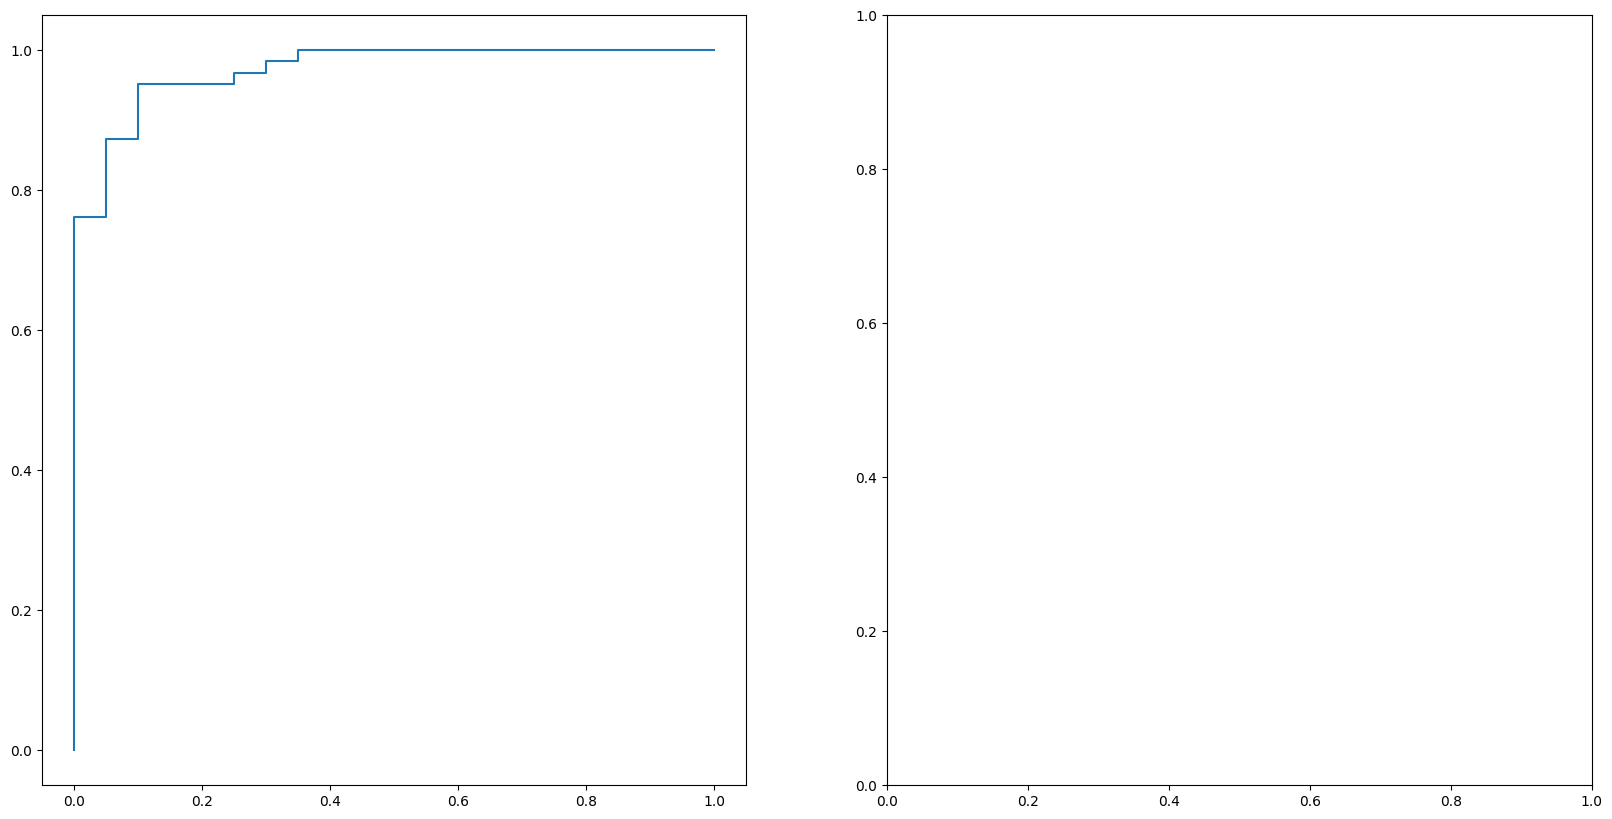

In [ ]:
import argparse
import numpy as np
import os
import pickle
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2

import datasets.mvtec as mvtec


def parse_args():
    parser = argparse.ArgumentParser('SPADE')
    parser.add_argument("--top_k", type=int, default=5)
    parser.add_argument("--save_path", type=str, default="./result")
    return parser.parse_args(args=[])  #parser.parse_args()


def main():

    args = parse_args()

    # device setup
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # load model
    model = wide_resnet50_2(pretrained=True, progress=True)
    model.to(device)
    model.eval()

    # set model's intermediate outputs
    outputs = []
    def hook(module, input, output):
        outputs.append(output)
    model.layer1[-1].register_forward_hook(hook)
    model.layer2[-1].register_forward_hook(hook)
    model.layer3[-1].register_forward_hook(hook)
    model.avgpool.register_forward_hook(hook)

    os.makedirs(os.path.join(args.save_path, 'temp'), exist_ok=True)

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    fig_img_rocauc = ax[0]
    fig_pixel_rocauc = ax[1]

    total_roc_auc = []
    total_pixel_roc_auc = []

    for class_name in mvtec.CLASS_NAMES:

        train_dataset = mvtec.MVTecDataset(class_name=class_name, is_train=True)
        train_dataloader = DataLoader(train_dataset, batch_size=32, pin_memory=True)
        test_dataset = mvtec.MVTecDataset(class_name=class_name, is_train=False)
        test_dataloader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

        train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', []), ('avgpool', [])])
        test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', []), ('avgpool', [])])

        # extract train set features
        train_feature_filepath = os.path.join(args.save_path, 'temp', 'train_%s.pkl' % class_name)
        if not os.path.exists(train_feature_filepath):
            for (x, y, mask) in tqdm(train_dataloader, '| feature extraction | train | %s |' % class_name):
                # model prediction
                with torch.no_grad():
                    pred = model(x.to(device))
                # get intermediate layer outputs
                for k, v in zip(train_outputs.keys(), outputs):
                    train_outputs[k].append(v)
                # initialize hook outputs
                outputs = []
            for k, v in train_outputs.items():
                train_outputs[k] = torch.cat(v, 0)
            # save extracted feature
            with open(train_feature_filepath, 'wb') as f:
                pickle.dump(train_outputs, f)
        else:
            print('load train set feature from: %s' % train_feature_filepath)
            with open(train_feature_filepath, 'rb') as f:
                train_outputs = pickle.load(f)

        gt_list = []
        gt_mask_list = []
        test_imgs = []

        # extract test set features
        for (x, y, mask) in tqdm(test_dataloader, '| feature extraction | test | %s |' % class_name):
            test_imgs.extend(x.cpu().detach().numpy())
            gt_list.extend(y.cpu().detach().numpy())
            gt_mask_list.extend(mask.cpu().detach().numpy())
            # model prediction
            with torch.no_grad():
                pred = model(x.to(device))
            # get intermediate layer outputs
            for k, v in zip(test_outputs.keys(), outputs):
                test_outputs[k].append(v)
            # initialize hook outputs
            outputs = []
        for k, v in test_outputs.items():
            test_outputs[k] = torch.cat(v, 0)

        # calculate distance matrix
        dist_matrix = calc_dist_matrix(torch.flatten(test_outputs['avgpool'], 1),
                                       torch.flatten(train_outputs['avgpool'], 1).to(device))

        # select K nearest neighbor and take average
        topk_values, topk_indexes = torch.topk(dist_matrix, k=args.top_k, dim=1, largest=False)
        scores = torch.mean(topk_values, 1).cpu().detach().numpy()

        # calculate image-level ROC AUC score
        fpr, tpr, _ = roc_curve(gt_list, scores)
        roc_auc = roc_auc_score(gt_list, scores)
        total_roc_auc.append(roc_auc)
        print('%s ROCAUC: %.3f' % (class_name, roc_auc))
        fig_img_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (class_name, roc_auc))

        score_map_list = []
        for t_idx in tqdm(range(test_outputs['avgpool'].shape[0]), '| localization | test | %s |' % class_name):
            score_maps = []
            for layer_name in ['layer1', 'layer2', 'layer3']:  # for each layer

                # このレイヤーで使う訓練データを、ループの最初にまとめてGPUへ転送する
                train_outputs_on_device = train_outputs[layer_name].to(device)

                # construct a gallery of features at all pixel locations of the K nearest neighbors
                # ↓↓↓ 参照する変数を変更 ↓↓↓
                # topk_feat_map = train_outputs_on_device[topk_indexes[t_idx]]
                # test_feat_map = test_outputs[layer_name][t_idx:t_idx + 1]
                # feat_gallery = topk_feat_map.transpose(3, 1).flatten(0, 2).unsqueeze(-1).unsqueeze(-1)

                # # calculate distance matrix
                # dist_matrix_list = []
                # for d_idx in range(feat_gallery.shape[0] // 100):
                #     dist_matrix = torch.pairwise_distance(feat_gallery[d_idx * 100:d_idx * 100 + 100], test_feat_map)
                #     dist_matrix_list.append(dist_matrix)
                # dist_matrix = torch.cat(dist_matrix_list, 0)

                # # k nearest features from the gallery (k=1)
                # score_map = torch.min(dist_matrix, dim=0)[0]
                # score_map = F.interpolate(score_map.unsqueeze(0).unsqueeze(0), size=224,
                #                           mode='bilinear', align_corners=False)
                # score_maps.append(score_map)

                # 正しい距離計算ロジック
                topk_feat_map = train_outputs_on_device[topk_indexes[t_idx]]  # Shape: (K, C, H, W)
                test_feat_map = test_outputs[layer_name][t_idx:t_idx + 1]    # Shape: (1, C, H, W)

                # galleryとtest mapの形状を、ピクセルごとの計算がしやすいように変形
                K, C, H, W = topk_feat_map.shape
                gallery_flat = topk_feat_map.permute(0, 2, 3, 1).reshape(K, H * W, C)
                test_flat = test_feat_map.permute(0, 2, 3, 1).reshape(1, H * W, C)

                # 各ピクセル位置で、テスト特徴とK個の正常特徴との距離を計算
                distances = torch.sqrt(torch.sum((gallery_flat - test_flat) ** 2, dim=2)) # Shape: (K, H*W)

                # 各ピクセル位置で、K個の正常特徴との距離のうち最小のものを異常スコアとする
                score_map_flat = torch.min(distances, dim=0)[0] # Shape: (H*W)

                # 異常スコアを2Dマップの形状に戻す
                score_map = score_map_flat.reshape(H, W)

                # 元の画像サイズにリサイズ
                score_map = F.interpolate(score_map.unsqueeze(0).unsqueeze(0), size=224,
                          mode='bilinear', align_corners=False)
                score_maps.append(score_map)



            # average distance between the features
            score_map = torch.mean(torch.cat(score_maps, 0), dim=0)

            # apply gaussian smoothing on the score map
            score_map = gaussian_filter(score_map.squeeze().cpu().detach().numpy(), sigma=4)
            score_map_list.append(score_map)

        flatten_gt_mask_list = np.concatenate(gt_mask_list).ravel()
        flatten_score_map_list = np.concatenate(score_map_list).ravel()

        # calculate per-pixel level ROCAUC
        fpr, tpr, _ = roc_curve(flatten_gt_mask_list, flatten_score_map_list)
        per_pixel_rocauc = roc_auc_score(flatten_gt_mask_list, flatten_score_map_list)
        total_pixel_roc_auc.append(per_pixel_rocauc)
        print('%s pixel ROCAUC: %.3f' % (class_name, per_pixel_rocauc))
        fig_pixel_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (class_name, per_pixel_rocauc))

        # get optimal threshold
        precision, recall, thresholds = precision_recall_curve(flatten_gt_mask_list, flatten_score_map_list)
        a = 2 * precision * recall
        b = precision + recall
        f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
        threshold = thresholds[np.argmax(f1)]

        # visualize localization result
        visualize_loc_result(test_imgs, gt_mask_list, score_map_list, threshold, args.save_path, class_name, vis_num=5)

    print('Average ROCAUC: %.3f' % np.mean(total_roc_auc))
    fig_img_rocauc.title.set_text('Average image ROCAUC: %.3f' % np.mean(total_roc_auc))
    fig_img_rocauc.legend(loc="lower right")

    print('Average pixel ROCUAC: %.3f' % np.mean(total_pixel_roc_auc))
    fig_pixel_rocauc.title.set_text('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
    fig_pixel_rocauc.legend(loc="lower right")

    fig.tight_layout()
    fig.savefig(os.path.join(args.save_path, 'roc_curve.png'), dpi=100)


def calc_dist_matrix(x, y):
    """Calculate Euclidean distance matrix with torch.tensor"""
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    dist_matrix = torch.sqrt(torch.pow(x - y, 2).sum(2))
    return dist_matrix


def visualize_loc_result(test_imgs, gt_mask_list, score_map_list, threshold,
                         save_path, class_name, vis_num=5):

    for t_idx in range(vis_num):
        test_img = test_imgs[t_idx]
        test_img = denormalization(test_img)
        test_gt = gt_mask_list[t_idx].transpose(1, 2, 0).squeeze()
        test_pred = score_map_list[t_idx]
        test_pred[test_pred <= threshold] = 0
        test_pred[test_pred > threshold] = 1
        test_pred_img = test_img.copy()
        test_pred_img[test_pred == 0] = 0

        fig_img, ax_img = plt.subplots(1, 4, figsize=(12, 4))
        fig_img.subplots_adjust(left=0, right=1, bottom=0, top=1)

        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)

        ax_img[0].imshow(test_img)
        ax_img[0].title.set_text('Image')
        ax_img[1].imshow(test_gt, cmap='gray')
        ax_img[1].title.set_text('GroundTruth')
        ax_img[2].imshow(test_pred, cmap='gray')
        ax_img[2].title.set_text('Predicted mask')
        ax_img[3].imshow(test_pred_img)
        ax_img[3].title.set_text('Predicted anomalous image')

        os.makedirs(os.path.join(save_path, 'images'), exist_ok=True)
        fig_img.savefig(os.path.join(save_path, 'images', '%s_%03d.png' % (class_name, t_idx)), dpi=100)
        fig_img.clf()
        plt.close(fig_img)


def denormalization(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)
    return x


if __name__ == '__main__':
    main()
